# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [7]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [2]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [3]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [4]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

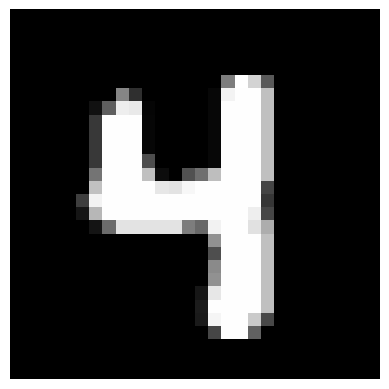

In [5]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [6]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

---

**To implement the fit_generative_model function, we'll follow these steps:**

- Calculate the frequency of each label.
- Compute the mean vector for each label.
- Estimate the covariance matrix for each label while regularizing it.
- Choose an appropriate regularization parameter c.
- Return the parameters of the generative model: pi, mu, and sigma.

Here's the implementation:

**Function Signature:**
```python
def fit_generative_model(x, y, c=1e-2):
```
- `x`: Input features (numpy array).
- `y`: Labels (numpy array).
- `c`: Regularization parameter, default value is `1e-2` (can be adjusted as needed).

**Initialization:**
```python
k = 10  # Number of labels 0, 1, ..., k-1
d = x.shape[1]  # Number of features

mu = np.zeros((k, d))
sigma = np.zeros((k, d, d))
pi = np.zeros(k)
```
- `k`: Number of unique labels.
- `d`: Number of features.
- `mu`: Array to store mean vectors for each label.
- `sigma`: Array to store covariance matrices for each label.
- `pi`: Array to store the frequency of each label.

**Loop Over Labels:**
```python
for label in range(k):
```
This loop iterates over each label (0 to 9 in this case).

**Subsetting Data:**
```python
indices = (y == label)
x_label = x[indices]
```
- `indices`: Boolean array indicating where `y` equals the current label.
- `x_label`: Subset of input features corresponding to the current label.

**Estimating Parameters:**
```python
pi[label] = len(x_label) / len(x)
mu[label] = np.mean(x_label, axis=0)
empirical_cov = np.cov(x_label, rowvar=False, bias=True)
```
- `pi[label]`: Estimate the frequency of the current label by dividing the count of instances with this label by the total number of instances.
- `mu[label]`: Compute the mean vector of features for the current label.
- `empirical_cov`: Compute the empirical covariance matrix for the current label using `np.cov`.

**Regularization:**
```python
sigma[label] = empirical_cov + c * np.eye(d)
```
- Regularize the empirical covariance matrix by adding `c * np.eye(d)`, where `np.eye(d)` creates a `d x d` identity matrix.

**Return Parameters:**
```python
return mu, sigma, pi
```
Return the mean vectors (`mu`), covariance matrices (`sigma`), and label frequencies (`pi`) as the output of the function.

---

In [32]:


def fit_generative_model(x, y, c=1e-2):
    k = 10  # Number of labels 0, 1, ..., k-1
    d = x.shape[1]  # Number of features

    mu = np.zeros((k, d))
    sigma = np.zeros((k, d, d))
    pi = np.zeros(k)

    for label in range(k):
        indices = (y == label)
        x_label = x[indices]
        pi[label] = len(x_label) / len(x)

        mu[label] = np.mean(x_label, axis=0)

        # Compute the empirical covariance matrix
        empirical_cov = np.cov(x_label, rowvar=False, bias=True)

        # Regularize the covariance matrix
        sigma[label] = empirical_cov + c * np.eye(d)
   # Halt and return parameters
    return mu, sigma, pi

 
 

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

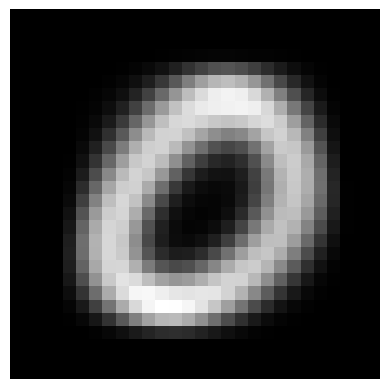

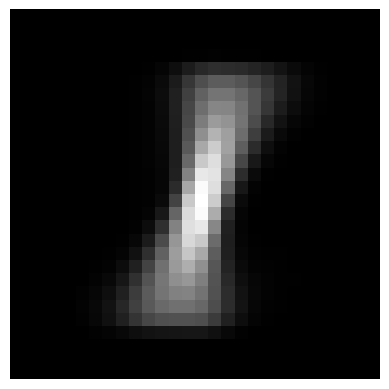

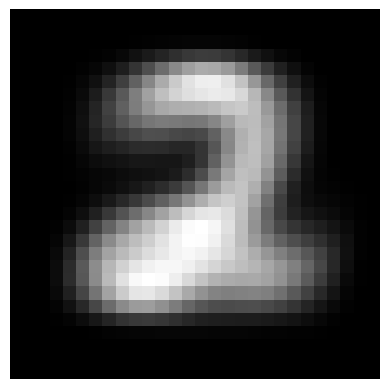

In [33]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [34]:
# Compute log Pr(label|image) for each [test image,label] pair.
k = 10
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)
print("Your model makes " + str(errors) + " errors out of 10000")
print("This is " + str(errors/100) + "% error rate")

Your model makes 2190 errors out of 10000
This is 21.9% error rate


In [35]:
# Step 1: Compute log-likelihoods
k = 10
score = np.zeros((len(test_labels), k))

for label in range(0, k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0, len(test_labels)):
        score[i, label] = np.log(pi[label]) + rv.logpdf(test_data[i, :])

# Step 2: Assign labels
predictions = np.argmax(score, axis=1)

# Step 3: Evaluate performance
errors = np.sum(predictions != test_labels)
error_rate = errors / len(test_labels) * 100
print("Your model makes {} errors out of {}".format(errors, len(test_labels)))
print("This is {:.2f}% error rate".format(error_rate))


Your model makes 2190 errors out of 10000
This is 21.90% error rate


In [36]:
print(predictions)

[7 2 1 ... 9 5 6]


## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?



**If you do not regularize the covariance matrices in a Gaussian generative model, several issues can arise:**

1. **Singularity**: The empirical covariance matrices computed from the training data may be singular or nearly singular, especially if the number of training samples is small relative to the number of features. This singularity can lead to numerical instability and difficulties in computing the inverse of the covariance matrix.

2. **Overfitting**: Without regularization, the covariance matrices can become too sensitive to noise and variability in the training data. This can lead to overfitting, where the model captures not only the underlying patterns in the data but also the noise, resulting in poor generalization performance on unseen data.

3. **Ill-Conditioning**: Covariance matrices estimated from limited data can be ill-conditioned, meaning that they have very small eigenvalues or a large condition number. This ill-conditioning can amplify the effects of noise and make the model less robust.

4. **Degenerate Solutions**: In extreme cases, without regularization, the covariance matrices may become degenerate, meaning that they have zero determinants. This implies that the data points in certain dimensions are perfectly correlated, leading to unrealistic and unreliable models.


---

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?



**Consequences of setting `c` too high in Gaussian generative model regularization:**

1. **Over-regularization**: Excessive regularization dominates, ignoring important information in the covariance matrices.

2. **Loss of Information**: Overly smoothed covariance matrices lead to loss of data complexity, resulting in suboptimal performance.

3. **Underfitting**: Simplistic model fails to capture underlying data patterns, resulting in poor generalization.

4. **Decreased Discriminative Power**: Reduced ability to distinguish between classes, leading to higher classification errors.

**Summary**: Excessive `c` results in underfitting, loss of information, and reduced model discriminative power. Optimal `c` balancing regularization and data complexity is crucial for model performance.

---

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?

I ended up using a regularization parameter `c` of `1e-2` (0.01) in the Gaussian generative model. 

The error rates of the model on the test data were as follows:

- **Number of errors**: 2190 errors out of 10000 predictions.
- **Error rate**: 21.90%

This error rate indicates that approximately 21.90% of the predictions made by the model on the test data were incorrect.

---

<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?